# Pymc Introduction

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
``
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

Create your first model!

Models in PyMC are centered around the Model class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context:

In [47]:
with pm.Model() as model:
    # Model definition
    pass

In [50]:
model.compile_logp()({})

array(0.)

In [53]:
with pm.Model() as model:
    # prior for mean of normal distribution
    # priors
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Normal("sigma", mu=1, sigma=1)
    # normal distribution with observed data, fixed sigma
    # data is a normal centered at 0
    # likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=rng.standard_normal(100))

In [54]:
print("Random variables:",model.basic_RVs)
print("Free random variables: ", model.free_RVs)

Random variables: [mu, sigma, obs]
Free random variables:  [mu, sigma]


In [59]:
model.compile_logp?

Signature:
model.compile_logp(
    vars: pytensor.graph.basic.Variable | collections.abc.Sequence[pytensor.graph.basic.Variable] | None = None,
    jacobian: bool = True,
    sum: bool = True,
    **compile_kwargs,
) -> pymc.pytensorf.PointFunc
Docstring:
Compiled log probability density function.

Parameters
----------
vars : list of random variables or potential terms, optional
    Compute the gradient with respect to those variables. If None, use all
    free and observed random variables, as well as potential terms in model.
jacobian : bool
    Whether to include jacobian terms in logprob graph. Defaults to True.
sum : bool
    Whether to sum all logp terms or return elemwise logp for each variable.
    Defaults to True.
File:      /opt/miniconda3/envs/env_gal/lib/python3.10/site-packages/pymc/model/core.py
Type:      method

In [58]:
model.compile_logp()({"mu": 0, 'sigma': 1})

array(-135.27568834)

## Sampling

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC supports two broad classes of inference: sampling and variational inference.

In [61]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

with model:
    idata = pm.sample(2000)
    # can be run in parallel
    # idata = pm.sample(cores=4, chains=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [63]:
# 4 chains and 2000 draw iterations
idata.posterior["mu"].shape

(4, 2000)

Select a single chains results

In [66]:
idata.posterior["mu"].sel(chain=0)

<xarray.DataArray 'mu' (draw: 2000)> Size: 16kB
array([-0.22614846, -0.25045733, -0.25045733, ..., -0.15786525,
       -0.15786525, -0.12329782])
Coordinates:
    chain    int64 8B 0
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999

## Analysing Sampling Results

In [114]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma = 5)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(1000))
    idata = pm.sample(2000, chains=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [mu, sd]


Output()

Sampling 10 chains for 1_000 tune and 2_000 draw iterations (10_000 + 20_000 draws total) took 4 seconds.


We can see a curve for each chain here

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

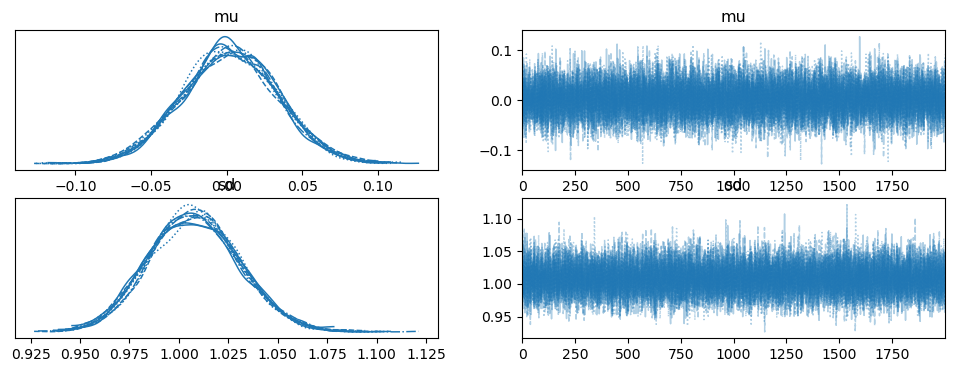

In [117]:

az.plot_trace(idata)

In [118]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.002,0.032,-0.055,0.064,0.0,0.0,20738.0,15170.0,1.0
sd,1.008,0.023,0.965,1.050,0.0,0.0,19955.0,15223.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

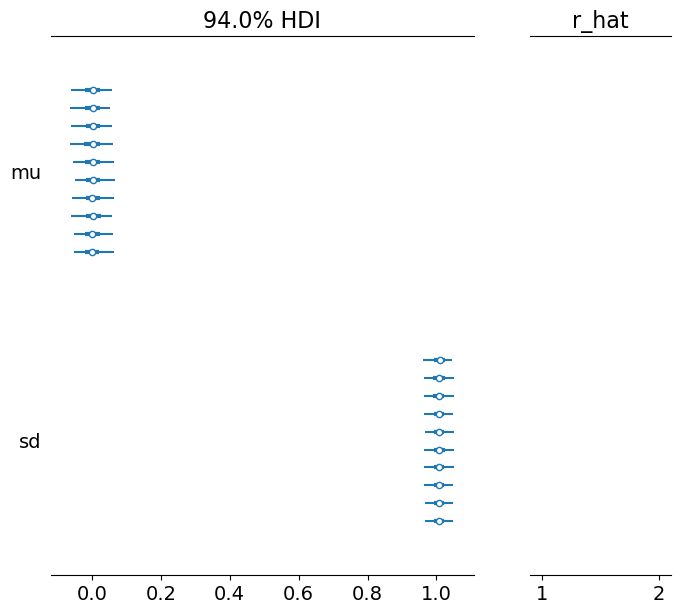

In [119]:
az.plot_forest(idata, r_hat=True)

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

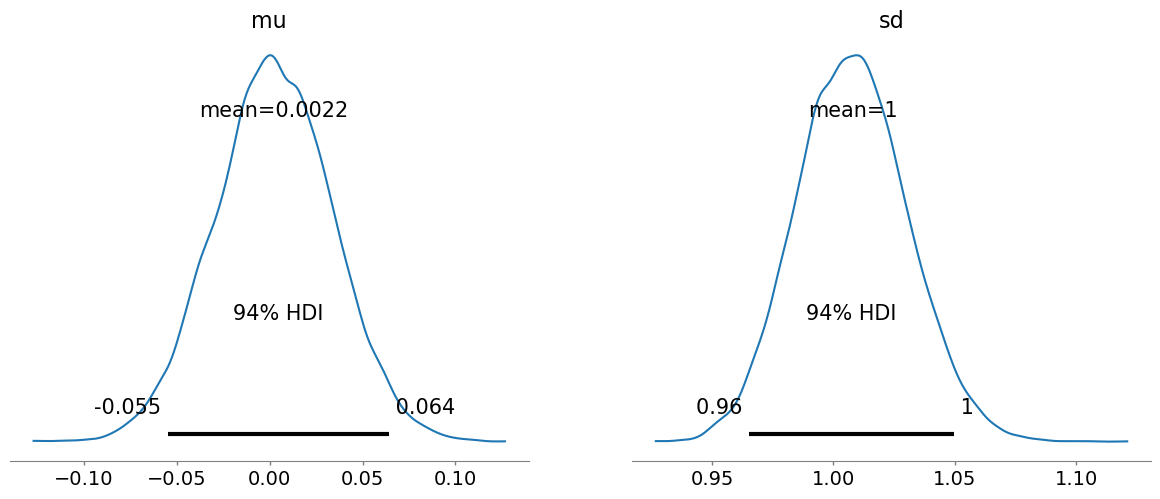

In [120]:
az.plot_posterior(idata)

For high-dimensional models it becomes cumbersome to look at the traces for all parameters. When using NUTS we can look at the energy plot to assess problems of convergence.

This compares the overall distribution of the energy levels with the change of energy between successive samples. Ideally, they should be very similar.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<AxesSubplot:>

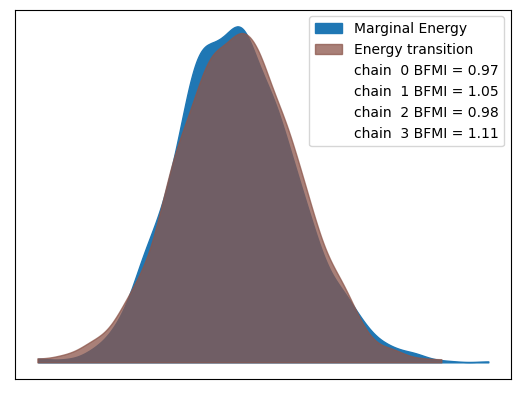

In [121]:
with pm.Model(coords={"idx": np.arange(100)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")
    idata = pm.sample()

az.plot_energy(idata)

## Variational Inference

In [122]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    approx = pm.fit()

Output()

Finished [100%]: Average Loss = 142.96


In [123]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.053,0.167,-0.357,0.263,0.005,0.004,998.0,958.0,NaN
sd,0.991,0.151,0.712,1.263,0.005,0.004,922.0,974.0,NaN


## Posterior Predictive
The sample_posterior_predictive() function performs prediction on hold-out data and posterior predictive checks.

In [34]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [35]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


Output()

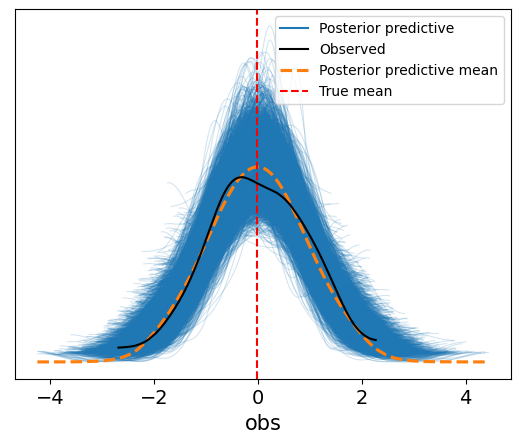

In [36]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10)

## Predicting on Hold Out Set

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. PyMC includes a pm.MutableData container to help with such uses. It is a wrapper around a pytensor.shared variable and allows the values of the data to be changed later. Otherwise, pm.MutableData objects can be used just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC are giant symbolic expressions. When you pass raw data directly into a model, you are giving PyTensor permission to treat this data as a constant and optimize it away if doing so makes sense. If you need to change this data later you may not have any way to point at it within the larger symbolic expression. Using pm.MutableData offers a way to point to a specific place in the symbolic expression and change what is there.

In [45]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.MutableData("x_obs", x, dims="idx")
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # cast to boolean
            "y_obs": np.array([0, 0, 0], dtype=bool),
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))


/opt/miniconda3/envs/env_gal/lib/python3.10/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Output()

In [46]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

<xarray.DataArray 'obs' (idx: 3)> Size: 24B
array([0.0285, 0.5055, 0.975 ])
Coordinates:
  * idx      (idx) int64 24B 1001 1002 1003

# Understanding the $\hat{R}$ Metric in Bayesian Models

The $\hat{R}$ metric, also known as the potential scale reduction factor or "R-hat," is used to assess the convergence of Markov Chain Monte Carlo (MCMC) simulations in Bayesian models. When running multiple MCMC chains to approximate the posterior distribution of model parameters, $\hat{R}$ helps determine if the chains have converged to the same distribution, which is crucial for ensuring reliable posterior estimates.

### Steps to Calculate $\hat{R}$

1. **Run multiple chains**: Start by running multiple independent MCMC chains (typically 4 or more) with different starting values to sample from the posterior distribution.

2. **Within-chain variance**  W:
   - For each chain, calculate the variance of the samples for a parameter within that chain.
   -  W is the average of these within-chain variances across all chains. It represents how much the samples vary within each chain, indicating the stability of individual chains.

3. **Between-chain variance** B:
   - For each chain, calculate the mean of the samples and then compute the variance of these means across chains.
   - B reflects how much the chain means differ from each other, indicating how similar or different the chains are overall.

4. **Estimate the target variance** ($\hat{\sigma}^2$):
   - Combine W and B to get an estimate of the total variance for the target posterior distribution:

     $\hat{\sigma}^2 = \frac{n - 1}{n} W + \frac{1}{n} B$

   where n is the number of samples per chain. This formula accounts for both the within-chain and between-chain variability.

5. **Compute $\hat{R}$**:
   - Finally, $\hat{R}$ is calculated as the ratio of the target variance estimate to the within-chain variance:

     $\hat{R} = \sqrt{\frac{\hat{\sigma}^2}{W}}$

   - If $\hat{R}$ $\approx$ 1, this indicates convergence, meaning that the within-chain and between-chain variances are similar, and the chains are likely sampling from the same distribution.
   - A value significantly greater than 1 suggests that the chains have not converged and may need more iterations.

### Interpreting $\hat{R}$
In practice:
- An $\hat{R}$ value below 1.05 is generally considered acceptable for convergence.
- Values closer to 1.0 are preferred, indicating better mixing and convergence among chains.

By using $\hat{R}$ to diagnose convergence, you can ensure that MCMC chains have explored the posterior space sufficiently, leading to reliable and stable parameter estimates.


## Energy Plots

# Understanding Energy Plots for the NUTS Sampler

Energy plots are diagnostic tools used in Hamiltonian Monte Carlo (HMC) and its adaptive variant, the No-U-Turn Sampler (NUTS), to assess sampling quality. In the context of HMC/NUTS, these plots can reveal issues like poor exploration of the posterior or inefficient sampling, which could lead to biased parameter estimates. Here’s a breakdown of what energy plots represent and how they’re interpreted:

### What is "Energy" in HMC/NUTS?
In HMC/NUTS, each proposed sample point in the posterior distribution corresponds to a value in an artificial energy landscape. This "energy" is a sum of two components:
1. **Potential energy** ($U$), which relates to the likelihood of a sample given the posterior distribution. This is like the "landscape" of our target distribution—the higher the probability of a parameter setting (a good fit for the data), the lower its potential energy. Low potential energy regions are where we want to take samples since they represent probable parameter values.
2. **Kinetic energy** ($K$), which is derived from an auxiliary momentum variable introduced to improve sampling efficiency. This is an artificial component that’s added to help move around the parameter space. You can think of it as an extra force that "pushes" the sampler around, helping it explore different regions.

The Hamiltonian, or total energy $H = U + K$, is conserved in an idealized setting, meaning that it should remain relatively constant if the sampler is exploring the posterior efficiently. However, due to numerical approximations, some variation in energy is expected.

When sampling, NUTS combines these energies to give each position a “total energy.” The algorithm then tries to keep this total energy consistent as it explores, making it easier to sample efficiently and avoid getting stuck in low-probability areas.

In simple terms, you can think of energy in NUTS as a way to balance where we want to sample (low potential energy) with how we move around to find good samples (kinetic energy).

If it moves a lot from a low potential to a high potential region, the total energy is large which is bad. If it moves a lot to a low potential region that is okay.

### Types of Energy Plots and Their Interpretations

1. **Energy vs. Iteration Plot**:
   - This plot shows the total energy $H$ of each sample over iterations.
   - Ideally, the total energy should fluctuate within a limited range, indicating stability in the sampler. Large, erratic changes in total energy may suggest numerical instability or that the sampler is struggling with high-curvature areas in the posterior.

2. **Energy Distribution Plot (Histogram of $\Delta H$)**:
   - This plot shows the distribution of changes in energy ($\Delta H$) between successive samples.
   - When the sampler is working well, $\Delta H$ should be centered close to zero, with a narrow distribution. Large shifts from zero indicate frequent rejections and poor sampling efficiency.
   - A high standard deviation in $\Delta H$ suggests inefficient sampling, meaning the chain may not be exploring the posterior distribution thoroughly.

3. **Energy Bayesian Fraction of Missing Information (BFMI)**:
   - BFMI measures how well the sampler's kinetic energy matches the target distribution. Low BFMI (typically below 0.3) indicates that the sampler is having trouble adapting to the posterior's shape, leading to inefficient exploration.
   - In a BFMI plot, you'd look for BFMI values close to 1, indicating that the kinetic energy distribution aligns well with the posterior distribution. Low BFMI can suggest the need to adjust the tuning parameters, such as step size or maximum tree depth.

### Diagnosing Issues with Energy Plots
- **High variance in total energy**: If total energy fluctuates significantly, the sampler might be poorly adapted to the posterior distribution, especially if there are regions of high curvature or multimodality.
- **Large changes in $\Delta H$**: A wide distribution of $\Delta H$ indicates inefficient sampling. This may call for adjusting NUTS tuning parameters (e.g., the step size) or reparametrizing the model.
- **Low BFMI**: Indicates that the momentum variable isn’t well-suited to explore the target distribution. In such cases, consider re-scaling parameters or simplifying the model structure.

### Summary
Energy plots in NUTS provide a window into the efficiency and stability of sampling. Smooth, consistent energy values, a narrow $\Delta H$ distribution around zero, and a high BFMI all indicate good sampling performance. By contrast, large energy fluctuations, high $\Delta H$ variance, and low BFMI suggest tuning or model adjustments are necessary to improve convergence and accuracy.
